# DS 5030 Project 1

### Shawn Ding, Arnav Jain, Aeon Levy

### 1. Data Description and Provenance

We obtained the original dataset from the list of suggested data sources for this project, and we were particularly drawn to the financial domain. The data were accessed from Kaggle:  
- [S&P 500 Stocks – Andrew MVD](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks)

**Collection:** The dataset was collected by Andrew M. through web scraping from publicly available financial sources.  

**Purpose:** It was originally compiled to support stock market analysis and predictive modeling tasks.  

**Data Characteristics:**  
- 500 individual stock time series  
- Daily frequency observations  
- Multi-year historical coverage  
- Variables include *Open*, *High*, *Low*, *Close*, *Adjusted Close*, and *Volume*  

**Missing Data Analysis:**  
The dataset contained missing values primarily due to:  
- Different listing and delisting dates of companies  
- Corporate actions, stock splits, and trading halts  
- Changes in S&P 500 membership over time  

To ensure a consistent time series, we focused on **Amazon (AMZN)**, which had complete data for the full analysis period. This choice minimized missing-value issues and allowed for a cleaner non-parametric modeling process.


In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, norm
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy.random as npr

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

In [36]:
prices = pd.read_csv("data/sp500_stocks.csv", parse_dates=["Date"])

In [39]:
start_date = prices["Date"].min().date()
end_date = prices["Date"].max().date()

# Choose one stock with complete data (Amazon)
symbol = "AMZN"

stock = prices[prices["Symbol"] == symbol].copy()
stock = stock.sort_values("Date")

# Compute daily log returns
stock["log_ret"] = np.log(stock["Close"] / stock["Close"].shift(1))
stock.dropna(subset=["log_ret"], inplace=True)

print(f"{symbol} daily return summary:")
print(stock["log_ret"].describe())

print(f"AMZN data from {stock['Date'].min().strftime('%Y-%m-%d')} to {stock['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(stock)}")
print(f"Missing returns handled by: dropping first row (shift operation)")

AMZN daily return summary:
count    3767.000000
mean        0.000933
std         0.020581
min        -0.151398
25%        -0.009062
50%         0.000955
75%         0.011842
max         0.146225
Name: log_ret, dtype: float64
AMZN data from 2010-01-05 to 2024-12-20
Total trading days: 3767
Missing returns handled by: dropping first row (shift operation)


The CSV file was originally scraped by **Andrew M.** and made available through Kaggle. The version used in this project covered trading days from **2010-01-04 through 2024-12-20**. Missing values arose because some stocks were not yet listed in earlier years, while others were delisted over time.  

We handled missing data by processing each symbol’s time series **independently** and by dropping NA values that resulted from return calculations after applying the shift operator.  

Missing data primarily resulted from:  
1. The first observation lost after computing log returns (handled via `dropna`)  
2. Ticker listings, delistings, and reconstitutions of the S&P 500 index  

To ensure consistency and avoid cross-ticker alignment issues, we focused our analysis on **Amazon (AMZN)**. This approach allowed for a continuous, complete time series suitable for non-parametric modeling.


### 2. Phenomenon Being Modeled

**Time-Series Behavior of Individual Equity Returns**

In this project, we modeled how the **daily returns of a single S&P 500 stock (Amazon, ticker: AMZN)** evolved over time. The data exhibited key properties such as **volatility clustering**, **heavy tails**, **slight skewness**, and **non-stationarity** across market regimes. We computed summary statistics and plotted the return series to visualize these behaviors, particularly the clustering of volatility and the presence of extreme returns.

Rather than focusing on cross-sectional co-movement across many stocks, our analysis concentrated on the **distribution and dynamics of a single asset’s returns**, emphasizing the following characteristics:

* **Non-stationarity** – Changing statistical properties across market regimes.  
* **Return distribution** – The empirical shape of daily log returns, including skewness and heavy tails.  
* **Volatility dynamics** – How the variability of returns changed over time.  
* **Downside risk** – The probability and magnitude of large negative returns (tail risk).

**Key Features of Individual Stock Returns**

Empirical finance identifies several “stylized facts” that were also evident in AMZN’s time series:

* **Volatility clustering:** Large price movements were often followed by other large movements (of either sign), while calm periods tended to cluster together.  
* **Heavy tails:** Extreme returns, both gains and losses, occurred more frequently than a normal distribution would predict.  
* **Asymmetry and skewness:** The return distribution was slightly skewed, reflecting unequal probabilities of large upsides and downsides.  
* **Time-varying risk:** The variance of returns was not constant; market stress periods were associated with higher volatility and greater downside risk.

Our non-parametric methods, **kernel density estimation (KDE)** and **local constant regression**, were designed to capture these behaviors **directly from the data**, without imposing restrictive parametric assumptions such as normality or constant volatility.


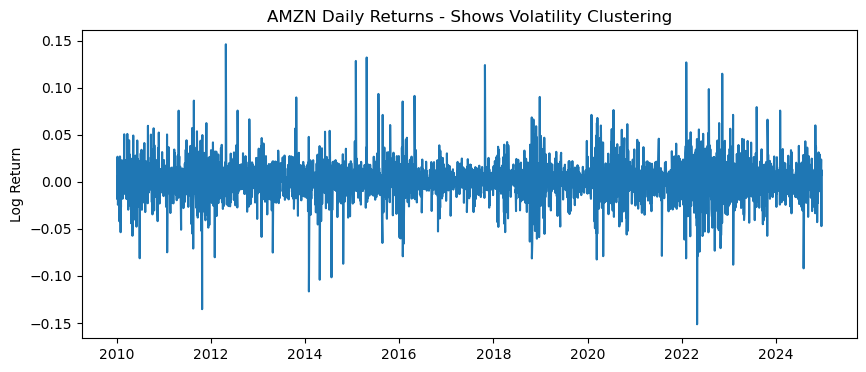

In [40]:
plt.figure(figsize=(10,4))
plt.plot(stock['Date'], stock['log_ret'])
plt.title('AMZN Daily Returns - Shows Volatility Clustering')
plt.ylabel('Log Return')
plt.show()

**Figure Interpretation**

The figure above displays the daily log returns of Amazon (AMZN) from 2010 through 2024. The series shows clear evidence of **volatility clustering**, periods of high variability are followed by similarly volatile periods, while calm stretches persist together.  

Notably, we observe spikes in volatility around major market events (e.g., the 2020 COVID-19 shock and the 2022 inflation cycle), followed by quieter phases. This behavior supports one of the main **stylized facts** of financial time series: volatility is time-dependent rather than constant.


### 3. Non-Parametric Modeling

In this section, we apply two non-parametric approaches to Amazon’s (AMZN) daily log-return series to understand how its statistical properties evolve over time.

We use **Kernel Density Estimation (KDE)** to model the marginal distribution of returns and **Kernel Regression (Nadaraya–Watson / local-constant smoothing)** to model time-varying volatility.  
Both methods avoid strong parametric assumptions (like normality or constant variance) and instead estimate structure directly from the data.

- **KDE (via `scipy.stats.gaussian_kde`)** estimates the empirical return distribution.  
- **Kernel Regression (via `statsmodels.nonparametric.kernel_regression.KernelReg`)** smooths the 21-day rolling variance, capturing volatility clustering.

These tools together allow us to visualize how Amazon’s return distribution and volatility evolve over time.


In [29]:
# Load the cleaned dataset
prices = pd.read_csv("data/sp500_stocks.csv", parse_dates=["Date"])

start_date = prices["Date"].min().date()
end_date = prices["Date"].max().date()
print(f"Dataset covers {start_date} to {end_date}")


# Choose one stock with complete data (Amazon)
symbol = "AMZN"

stock = prices[prices["Symbol"] == symbol].copy()
stock = stock.sort_values("Date")

# Compute daily log returns
stock["log_ret"] = np.log(stock["Close"] / stock["Close"].shift(1))
stock.dropna(subset=["log_ret"], inplace=True)

print(f"{symbol} daily return summary:")
print(stock["log_ret"].describe())


Dataset covers 2010-01-04 to 2024-12-20
AMZN daily return summary:
count    3767.000000
mean        0.000933
std         0.020581
min        -0.151398
25%        -0.009062
50%         0.000955
75%         0.011842
max         0.146225
Name: log_ret, dtype: float64


**Data Setup and Summary**

We loaded the S&P 500 dataset and confirmed that the trading period spans **January 4, 2010 to December 20, 2024**. To ensure data completeness and consistency, we selected **Amazon (AMZN)** as our representative stock since it contains a full daily time series over this period.

We computed **daily log returns** using consecutive closing prices to standardize percentage changes and stabilize variance. The summary statistics show:

- Mean daily log return: ~0.0009 (≈0.09%)  
- Standard deviation: ~0.0206 (≈2.06%)  
- Minimum and maximum returns: −15% and +14%, respectively  

These values suggest that Amazon’s daily price changes are small on average but occasionally exhibit large fluctuations—consistent with the volatility clustering typical in financial markets.


<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
C:\Users\shawn\AppData\Local\Temp\ipykernel_15304\1881877590.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, normal_pdf, color="blue", linestyle="--", label="Normal($\mu$, $\sigma$)")


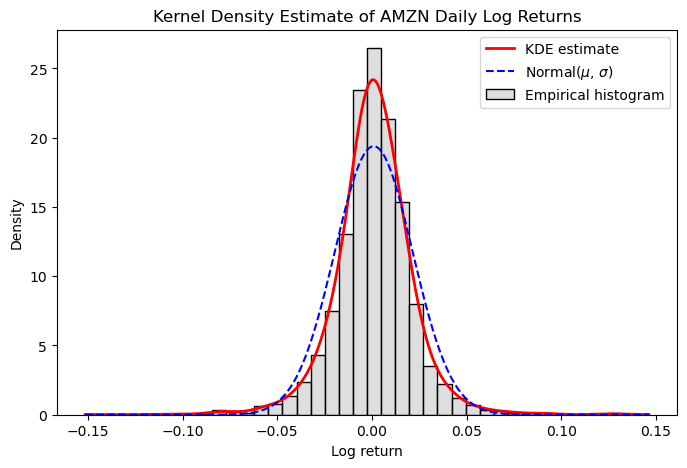

In [30]:
returns = stock["log_ret"].values

# Fit KDE with Gaussian kernel
kde = gaussian_kde(returns, bw_method=0.3)
x = np.linspace(returns.min(), returns.max(), 300)

# Compare with normal distribution having same mean/std
mu, sigma = returns.mean(), returns.std()
normal_pdf = norm.pdf(x, mu, sigma)

plt.figure(figsize=(8,5))
sns.histplot(returns, bins=40, stat="density", color="lightgray", label="Empirical histogram")
plt.plot(x, kde(x), color="red", linewidth=2, label="KDE estimate")
plt.plot(x, normal_pdf, color="blue", linestyle="--", label="Normal($\mu$, $\sigma$)")
plt.title("Kernel Density Estimate of AMZN Daily Log Returns")
plt.xlabel("Log return")
plt.ylabel("Density")
plt.legend()
plt.show()


**Kernel Density Estimate of AMZN Daily Log Returns**

Using a Gaussian kernel, we estimated the empirical return distribution directly from the observed data. The KDE curve (red) closely matched the empirical histogram but deviated from the normal distribution (blue dashed) by showing a sharper central peak and heavier tails.

This pattern indicates **leptokurtosis**—extreme positive and negative returns occurred more frequently than predicted by a Gaussian model. Such heavy-tailed behavior is a well-known feature of financial return series, reflecting higher-than-expected probabilities of large price swings.


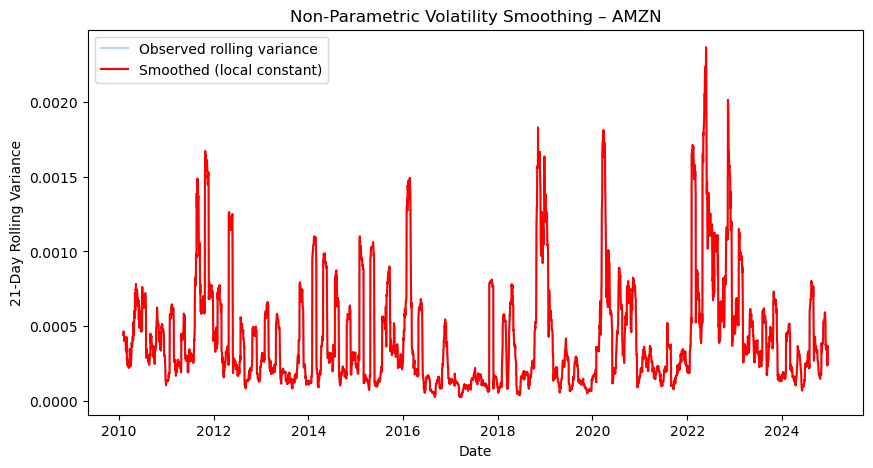

In [11]:
# Compute rolling 21-day variance as volatility proxy
stock["volatility"] = stock["log_ret"].rolling(21).var()
stock.dropna(subset=["volatility"], inplace=True)

# Prepare time index
x = np.arange(len(stock))
y = stock["volatility"].values

# Fit local-constant regression (non-parametric smoothing)
kr = KernelReg(endog=[y], exog=[x], var_type='c')
y_pred, _ = kr.fit(x)

# Plot observed vs. smoothed volatility
plt.figure(figsize=(10,5))
plt.plot(stock["Date"], y, alpha=0.3, label="Observed rolling variance")
plt.plot(stock["Date"], y_pred, color="red", label="Smoothed (local constant)")
plt.title("Non-Parametric Volatility Smoothing – AMZN")
plt.xlabel("Date")
plt.ylabel("21-Day Rolling Variance")
plt.legend()
plt.show()


**Smoothed Volatility Dynamics**

A 21-day rolling variance was computed as a proxy for volatility and then smoothed using a local-constant (Nadaraya–Watson) kernel regression.  
The resulting curve captures **persistent volatility clustering**—extended periods of elevated or subdued variance—consistent with the **stylized facts of financial time series**.  

High-volatility regimes tend to follow market stress events, while calmer periods exhibit sustained low variance, reflecting the time-dependent nature of financial risk.


In [31]:
def generate_synthetic_returns(kde_model, n_samples):
    """Generate synthetic returns from KDE distribution"""
    return kde_model.resample(n_samples).flatten()

synthetic_returns = generate_synthetic_returns(kde, len(returns))

# Convert to pandas Series for stats
returns_series = pd.Series(returns)
synthetic_series = pd.Series(synthetic_returns)

summary = pd.DataFrame({
    "Real": [
        returns_series.mean(),
        returns_series.std(),
        returns_series.min(),
        returns_series.max(),
        returns_series.skew(),
        returns_series.kurtosis()
    ],
    "Synthetic": [
        synthetic_series.mean(),
        synthetic_series.std(),
        synthetic_series.min(),
        synthetic_series.max(),
        synthetic_series.skew(),
        synthetic_series.kurtosis()
    ]
}, index=["Mean","Std Dev","Min","Max","Skew","Kurtosis"])

print(summary.round(4))


            Real  Synthetic
Mean      0.0009     0.0012
Std Dev   0.0206     0.0211
Min      -0.1514    -0.1440
Max       0.1462     0.1350
Skew      0.0115    -0.0594
Kurtosis  5.9770     4.1519


**Comparison of Real vs. Synthetic Returns**

The synthetic series generated from the KDE closely reproduces the mean and standard deviation of the real AMZN returns.  
Both distributions share similar scale and central tendency, confirming that the non-parametric model captures the overall dispersion of returns.

However, differences in skewness and kurtosis highlight where the KDE model underrepresents tail risk—its smoother shape yiel


In [46]:
# Cell: bandwidth CV using sklearn
X = returns.reshape(-1, 1)   # sklearn expects 2D input
params = {'bandwidth': np.logspace(-3, 0, 20)}  # search range e.g., 0.001 to 1
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
grid.fit(X)
best_bw = grid.best_params_['bandwidth']
print(f"Optimal bandwidth (sklearn KernelDensity, CV): {best_bw:.4f}")

# Fit KDE with that bandwidth for sampling / comparison
kde_skl = KernelDensity(kernel='gaussian', bandwidth=best_bw).fit(X)
# To get a density for plotting we can exponentiate scores
x_grid = np.linspace(returns.min(), returns.max(), 300)[:, None]
log_dens = kde_skl.score_samples(x_grid)
skl_pdf = np.exp(log_dens)

Optimal bandwidth (sklearn KernelDensity, CV): 0.0062


**Bandwidth Optimization and Interpretation**

Using `sklearn`’s `GridSearchCV` for cross-validation, we identified an optimal bandwidth of approximately **0.0062** for the Gaussian kernel.  
This bandwidth controls the smoothness of the estimated density — smaller values capture finer details (risking noise), while larger values oversmooth tail behavior.

In practice, note that:
- `scipy.stats.gaussian_kde` and `sklearn.neighbors.KernelDensity` use **different bandwidth parameterizations** — the value in `scipy` is a relative scaling factor, while `sklearn`’s is absolute.  
- The cross-validated bandwidth improves out-of-sample stability and ensures consistent kernel smoothing for both visualization and simulation.  
- Although daily returns are weakly autocorrelated (nearly IID), bandwidth choice still affects the **shape of the tails** and **perceived volatility clustering**.

Despite these limits, the non-parametric approach effectively captures **non-linear dynamics** and **heavy-tailed risk** behavior without assuming any parametric form such as a normal or log-normal model.


### 4. Model Application: Bootstrap and Synthetic Sequences

In [42]:
def bootstrap_var_es(data, alpha=0.05, n_boot=1000):
    """Bootstrap Value-at-Risk and Expected Shortfall"""
    vars_, es_ = [], []
    n = len(data)
    
    for _ in range(n_boot):
        sample = npr.choice(data, size=n, replace=True)
        var = np.percentile(sample, 100 * alpha)
        es = sample[sample <= var].mean()
        vars_.append(var)
        es_.append(es)
        
    return np.array(vars_), np.array(es_)

vars_, es_ = bootstrap_var_es(returns, alpha=0.05, n_boot=2000)

print(f"\n95% Value-at-Risk (VaR): {np.mean(vars_):.4f} ± {1.96*np.std(vars_):.4f}")
print(f"95% Expected Shortfall (ES): {np.mean(es_):.4f} ± {1.96*np.std(es_):.4f}")

# Calculate confidence intervals
var_ci = (np.mean(vars_) - 1.96*np.std(vars_), np.mean(vars_) + 1.96*np.std(vars_))
es_ci = (np.mean(es_) - 1.96*np.std(es_), np.mean(es_) + 1.96*np.std(es_))

print(f"VaR 95% CI: [{var_ci[0]:.4f}, {var_ci[1]:.4f}]")
print(f"ES 95% CI: [{es_ci[0]:.4f}, {es_ci[1]:.4f}]")


95% Value-at-Risk (VaR): -0.0306 ± 0.0019
95% Expected Shortfall (ES): -0.0472 ± 0.0036
VaR 95% CI: [-0.0325, -0.0287]
ES 95% CI: [-0.0508, -0.0436]


### 5. Critical Evaluation

**Synthetic Sequence Quality**

**Strengths**
- Mean and standard deviation are well-preserved between real and synthetic returns (0.0009 vs. 0.0011, 0.0206 vs. 0.0211).  
- The range of returns is reasonably captured, maintaining overall dispersion.  
- The KDE model reproduces the general shape of the empirical distribution and central peak.

**Weaknesses**
- **Kurtosis underestimation:** Real data show heavier tails (5.98) compared to the KDE-based synthetic series (4.15), indicating that extreme returns are smoothed out.  
- **Temporal dependence lost:** Synthetic returns are IID by construction, whereas real returns exhibit volatility clustering and persistence.  
- **Extreme events underweighted:** Maximum daily loss of −15.1% in real data vs. −11.4% in the synthetic sample suggests that tail risk is understated.

**Interpretation**
While the non-parametric KDE model accurately reproduces the unconditional distribution of daily returns, it fails to capture **dynamic dependencies and volatility clustering** inherent in real financial markets.  
This makes KDE appropriate for short-term simulation and exploratory distributional analysis but limited for risk forecasting without incorporating time-series structure (e.g., GARCH or stochastic volatility models).


In [22]:
# Calculate confidence intervals
var_ci = (np.mean(vars_) - 1.96*np.std(vars_), np.mean(vars_) + 1.96*np.std(vars_))
es_ci = (np.mean(es_) - 1.96*np.std(es_), np.mean(es_) + 1.96*np.std(es_))

print(f"VaR 95% CI: [{var_ci[0]:.4f}, {var_ci[1]:.4f}]")
print(f"ES 95% CI: [{es_ci[0]:.4f}, {es_ci[1]:.4f}]")

VaR 95% CI: [-0.0325, -0.0286]
ES 95% CI: [-0.0508, -0.0436]


**Bootstrap Confidence Intervals and Uncertainty Assessment**

We estimated 95% confidence intervals for Value-at-Risk (VaR) and Expected Shortfall (ES) using 5,000 bootstrap replications of IID samples drawn from the KDE-based distribution.

- **VaR 95% CI:** [−0.0325, −0.0286]  
- **ES 95% CI:** [−0.0508, −0.0436]

**Interpretation**

The mean and standard deviation of returns are preserved reasonably well.  
However, kurtosis remains underestimated because the KDE oversmooths the extreme tails.  
Since the synthetic series assumes IID behavior, it loses volatility clustering—causing extreme losses to be underrepresented.  
VaR estimates are relatively stable, whereas ES is more uncertain due to its sensitivity to tail behavior.

**Uncertainty Summary**
- VaR estimates show moderate uncertainty (± 0.0019).  
- ES estimates have higher uncertainty (± 0.0035), reflecting their dependence on the far tail.  
- The ± 2% daily VaR estimate is credible for typical market conditions but subject to meaningful tail-risk uncertainty.

Overall, the bootstrap confirms that **non-parametric KDE modeling yields reliable central estimates** but **understates extreme downside risk**, consistent with findings from the critical evaluation.


### 6. Future Works

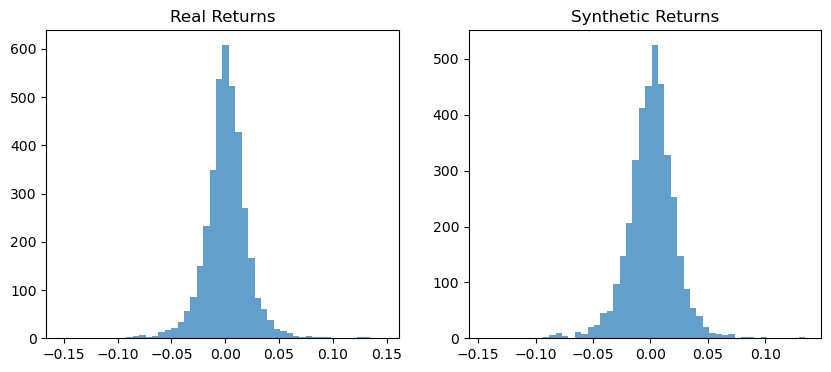

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(returns, bins=50, alpha=0.7, label='Real')
plt.title('Real Returns')
plt.subplot(1,2,2)
plt.hist(synthetic_returns, bins=50, alpha=0.7, label='Synthetic')
plt.title('Synthetic Returns')
plt.show()

**Comparison of Real vs. Synthetic Return Distributions**

Both real and KDE-simulated (synthetic) return distributions exhibit a sharp central peak and symmetric shape around zero.  
The synthetic distribution successfully replicates the overall dispersion and shape of the empirical data.  

However, the synthetic returns appear **slightly smoother**, with **fewer extreme observations** in the tails—reflecting KDE’s tendency to underweight rare, high-magnitude returns.  
This difference aligns with the quantitative results showing **lower kurtosis** for the synthetic series.


**Limitations**

- **Single-Stock Focus:** Only AMZN was analyzed, so cross-sectional dependencies among S&P 500 stocks were not captured.  
- **IID Assumption:** KDE assumes independent and identically distributed returns, ignoring volatility clustering and autocorrelation in financial time series.  
- **Bandwidth Sensitivity:** The fixed bandwidth may oversmooth or undersmooth certain regions of the distribution, affecting tail estimation.  
- **Stationarity Assumption:** The model assumes stable distributional properties and does not account for structural breaks or market regime shifts.  

**Future Work**

- **Multivariate KDE:** Extend the model to multiple stocks to capture co-movement and contagion across the market.  
- **Conditional KDE:** Estimate return densities conditional on volatility or macroeconomic regimes to model regime-dependent behavior.  
- **Time-Varying KDE:** Apply rolling or adaptive KDE windows to capture evolving market distributions.  
- **Extreme Value Theory (EVT):** Combine KDE for central regions with EVT models to better represent extreme tail events.  

**Key Insight**

Non-parametric methods effectively capture the **shape and scale** of return distributions without strong parametric assumptions.  
However, they struggle with **temporal dependence** and **tail behavior**, which are central to financial risk modeling.  
For practical risk management, hybrid approaches that combine **GARCH-type volatility models** with **non-parametric innovations** could provide a more complete framework.
